# 3D SIP inversion

**Author**: Seogi Kang

This notebook runs 3D SIP inversion. 

In [1]:
from SimPEG import DC, SIP
import numpy as np
from SimPEG import Mesh, Maps, Utils
from pymatsolver import PardisoSolver
from ipywidgets import *
from matplotlib import colors
import h5py
from pylab import cm
from matplotlib import gridspec

In [2]:
fname = 'output_simulation_sip.h5'
output_simulation = h5py.File(fname, 'r')
times = output_simulation['times'].value
geology_names = np.array(["background", "overburden","porphyry", "stock", "halo", "clay", "mineralization"], dtype=str),    
fname = 'output_dc_inversion.h5'
output_dc_inversion = h5py.File(fname, 'r')
mesh = Mesh.TensorMesh.readUBC(output_simulation['mesh_name'].value)
sigma = output_simulation['sigma'].value
eta = output_simulation['eta'].value
tau = output_simulation['tau'].value
c = output_simulation['c'].value
import numpy as np
from SimPEG import (
    Maps, DataMisfit, Regularization,
    Optimization, Inversion, InvProblem, Directives
)


def run_inversion(
    m0, survey, actind, mesh, wires,
    std, eps,
    maxIter=15, beta0_ratio=1e0,
    coolingFactor=2, coolingRate=2,
    maxIterLS=20, maxIterCG=20, LSshorten=0.5,
    eta_lower=1e-5, eta_upper=1,
    tau_lower=1e-6, tau_upper=10.,
    c_lower=1e-2, c_upper=1.,
    is_log_tau=True,
    is_log_c=True,
    is_log_eta=True,
    mref=None,
    alpha_s=1e-4,
    alpha_x=1e0,
    alpha_y=1e0,
    alpha_z=1e0,
):
    """
    Run Spectral Spectral IP inversion
    """
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    uncert = abs(survey.dobs) * std + eps
    dmisfit.W = 1./uncert
    # Map for a regularization
    # Related to inversion

    # Set Upper and Lower bounds
    e = np.ones(actind.sum())

    if np.isscalar(eta_lower):
        eta_lower = e * eta_lower
    if np.isscalar(tau_lower):
        tau_lower = e * tau_lower
    if np.isscalar(c_lower):
        c_lower = e * c_lower

    if np.isscalar(eta_upper):
        eta_upper = e * eta_upper
    if np.isscalar(tau_upper):
        tau_upper = e * tau_upper
    if np.isscalar(c_upper):
        c_upper = e * c_upper

    if is_log_eta:
        eta_upper = np.log(eta_upper)
        eta_lower = np.log(eta_lower)

    if is_log_tau:
        tau_upper = np.log(tau_upper)
        tau_lower = np.log(tau_lower)

    if is_log_c:
        c_upper = np.log(c_upper)
        c_lower = np.log(c_lower)

    m_upper = np.r_[eta_upper, tau_upper, c_upper]
    m_lower = np.r_[eta_lower, tau_lower, c_lower]

    # Set up regularization
    reg_eta = Regularization.Sparse(
        mesh, mapping=wires.eta, indActive=actind
        )
    reg_tau = Regularization.Sparse(
        mesh, mapping=wires.tau, indActive=actind
        )
    reg_c = Regularization.Sparse(mesh, mapping=wires.c, indActive=actind)

    # Todo:

    reg_eta.alpha_s = alpha_s
    reg_tau.alpha_s = alpha_s
    reg_c.alpha_s = alpha_s

    reg_eta.alpha_x = alpha_x
    reg_tau.alpha_x = alpha_x
    reg_c.alpha_x = alpha_x

    reg_eta.alpha_y = alpha_y
    reg_tau.alpha_y = alpha_y
    reg_c.alpha_y = alpha_y

    reg_eta.alpha_z = alpha_z
    reg_tau.alpha_z = alpha_z
    reg_c.alpha_z = alpha_z
    reg_eta.norms = np.c_[0, 2, 2, 2]
    reg_tau.norms = np.c_[0, 2, 2, 2]
    reg_c.norms = np.c_[2, 2, 2, 2]
    reg = reg_eta + reg_tau + reg_c

    # Use Projected Gauss Newton scheme
    opt = Optimization.ProjectedGNCG(
        maxIter=maxIter, upper=m_upper, lower=m_lower,
        maxIterLS=maxIterLS, maxIterCG=maxIterCG, LSshorten=LSshorten
        )
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    beta = Directives.BetaSchedule(
        coolingFactor=coolingFactor, coolingRate=coolingRate
    )
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
    target = Directives.TargetMisfit()
    directiveList = [
                beta, betaest, target
    ]

    inv = Inversion.BaseInversion(
        invProb, directiveList=directiveList
        )
    opt.LSshorten = 0.5
    opt.remember('xc')

    # Run inversion
    mopt = inv.run(m0)
    return mopt, invProb.dpred

IO_3d = DC.IO()
survey_3d = IO_3d.from_ambn_locations_to_survey(
    survey_type='dipole-dipole',
    a_locations=output_simulation['a_locations'].value,
    b_locations=output_simulation['b_locations'].value,
    m_locations=output_simulation['m_locations'].value,
    n_locations=output_simulation['n_locations'].value,
    data_dc=output_simulation['dc_data'].value,
    data_dc_type='volt',
    data_sip=output_simulation['sip_data'].value,    
    data_sip_type='volt',
    line_inds = output_simulation['line_inds'].value,
    dimension=3
)
mesh_3d, actind = IO_3d.set_mesh(dx=25., dy=50., dz=15., dimension=3)

eta_map, tau_map, c_map, wires = SIP.spectral_ip_mappings(
    mesh_3d, indActive=actind, 
    is_log_eta = True,
    is_log_tau = True,
    is_log_c = True,    
)

problem = SIP.Problem3D_N(
    mesh_3d, sigma=output_dc_inversion['sigma'].value, etaMap=eta_map, tauMap=tau_map, cMap=c_map,
    storeJ=True, verbose=False,
    Solver=PardisoSolver,
    data_type="apparent_chargeability"
)
survey_3d_sip = SIP.from_dc_to_sip_survey(survey_3d, times)
survey_3d_sip.n_pulse = 2
survey_3d_sip.T = 16
survey_3d_sip.unpair()
problem.pair(survey_3d_sip)

eta0 = np.zeros(actind.sum()) + 1e-2
tau0 = np.ones(actind.sum()) * 0.1
c0 = np.ones(actind.sum()) * 1.0
m0 = np.r_[np.log(eta0[actind]), np.log(tau0[actind]), np.log(c0[actind])]
mref = np.r_[np.log(1e-2)*np.ones(actind.sum()), np.log(tau0[actind]), np.log(c0[actind])]
# eps = Utils.mkvc(abs(np.repeat(IO_3d.data_dc.reshape([-1,1]), times.size, axis=1)) * 0.25e-3)
# eps += 10**-5
# std = 0.05
eps = 8e-4
std = 0.05
survey_3d_sip.dobs = Utils.mkvc(Utils.sdiag(1./IO_3d.data_dc)*IO_3d.data_sip)
mopt, pred = run_inversion(
    m0, survey_3d_sip, actind, mesh_3d, wires, std, eps, 
    is_log_eta=True, 
    is_log_tau=True, 
    is_log_c=True,     
    maxIter=30, 
    tau_upper=100.,
    alpha_s=0.1
)

eta_est = np.exp(wires.eta * mopt)
tau_est = np.exp(wires.tau * mopt)
c_est = np.exp(wires.c * mopt)
core_3d_inds, mesh_3d_core = Utils.ExtractCoreMesh(IO_3d.xyzlim, mesh_3d)

import h5py
mesh_name = 'mesh_3d_sip.txt'
mesh_3d.writeUBC(mesh_name)
output_sip_inversion = {
    'eta': eta_est,
    'tau': tau_est,
    'c': c_est,    
    'sip_data': survey_3d_sip.dobs,
    'sip_data_pred': pred
}
def save_dict_to_hdf5(fname, dictionary):
    """
    Save a dictionary to hdf5
    """
    f = h5py.File(fname, "w")
    for key in dictionary.keys():
        dset = f.create_dataset(key, data=dictionary[key])
    f.close()

/Users/sgkang/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/sgkang/Projects/simpeg/SimPEG/EM/Static/DC/IODC.py:232: UserWarning: code under construction - API might change in the future
  "code under construction - API might change in the future"


You did not put Active indices
So, set actMap = IdentityMap(mesh)
SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.45e-05  7.60e+05  0.00e+00  7.60e+05    8.01e+02      0              
   1  2.45e-05  2.47e+05  4.93e+07  2.48e+05    6.85e+02      2              
   2  1.23e-05  9.08e+04  7.36e+07  9.17e+04    1.12e+03      0        

In [9]:
save_dict_to_hdf5('output_sip_inversion.h5', output_sip_inversion)

Populating the interactive namespace from numpy and matplotlib


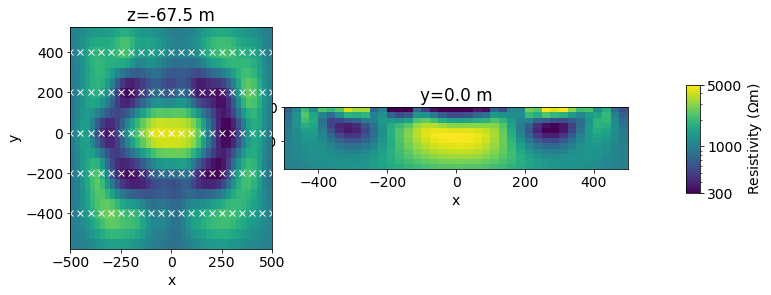

In [10]:
%pylab inline
import matplotlib
from matplotlib import colors
matplotlib.rcParams['font.size'] = 14
sigma_est  =output_dc_inversion['sigma'].value
yc = 0
indy = int(np.argmin(abs(mesh_3d_core.vectorCCy-yc)))
zc = -70
indz = int(np.argmin(abs(mesh_3d_core.vectorCCz-zc)))

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 8)
ax1 = plt.subplot(gs[0, 3:])
ax2 = plt.subplot(gs[0, :3])
vmin, vmax = 300, 5000.
out = mesh_3d_core.plotSlice(
    1./sigma_est[core_3d_inds], grid=False, normal="Y", clim=(vmin, vmax), pcolorOpts={'cmap':'viridis', 'norm':colors.LogNorm()}, ax=ax1, ind=indy
)
ax1.set_aspect("equal")
ax1.set_title(("y=%.1f m")%(mesh_3d_core.vectorCCy[indy]))
out = mesh_3d_core.plotSlice(
    1./sigma_est[core_3d_inds], grid=False, normal="Z", clim=(vmin, vmax), ind=indz, pcolorOpts={'cmap':'viridis', 'norm':colors.LogNorm()}, 
    ax=ax2
)
ax2.set_aspect(1)
ax2.set_title(("z=%.1f m")%(mesh_3d_core.vectorCCz[indz]))
ax2.plot(IO_3d.electrode_locations[:,0], IO_3d.electrode_locations[:,1], 'wx', markeredgewidth=1.)
cbaxes = fig.add_axes([0.98, 0.35, 0.02, 0.3]) 
cb=plt.colorbar(
    out[0], cax=cbaxes, orientation="vertical", ax=ax1, ticks=[300, 1000., 5000.]
)

cb.set_ticklabels(np.array([300, 1000., 5000.], dtype=int))
cb.set_label("Resistivity ($\Omega$m)")
for ax in [ax1, ax2]:
    ax.set_xlim(-500, 500)
#     ax.set_ylim(-500, 500)    
plt.tight_layout()


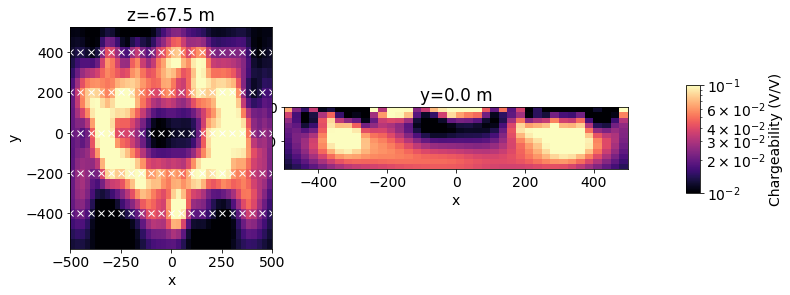

In [11]:
yc = 0
indy = int(np.argmin(abs(mesh_3d_core.vectorCCy-yc)))
zc = -70
indz = int(np.argmin(abs(mesh_3d_core.vectorCCz-zc)))
cmap = 'magma'
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 8)
ax1 = plt.subplot(gs[0, 3:])
ax2 = plt.subplot(gs[0, :3])
vmin, vmax = 0.01, 0.1
out = mesh_3d_core.plotSlice(
    eta_est[core_3d_inds], grid=False, normal="Y", clim=(vmin, vmax), pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, ax=ax1, ind=indy
)
ax1.set_aspect("equal")
ax1.set_title(("y=%.1f m")%(mesh_3d_core.vectorCCy[indy]))
out = mesh_3d_core.plotSlice(
    eta_est[core_3d_inds], grid=False, normal="Z", clim=(vmin, vmax), ind=indz, pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, 
    ax=ax2
)
ax2.set_aspect(1)
ax2.set_title(("z=%.1f m")%(mesh_3d_core.vectorCCz[indz]))
ax2.plot(IO_3d.electrode_locations[:,0], IO_3d.electrode_locations[:,1], 'wx', markeredgewidth=1.)
cbaxes = fig.add_axes([0.98, 0.35, 0.02, 0.3]) 
cb=plt.colorbar(
    out[0], cax=cbaxes, orientation="vertical", ax=ax1
)

cb.set_label("Chargeability (V/V)")
for ax in [ax1, ax2]:
    ax.set_xlim(-500, 500)
#     ax.set_ylim(-500, 500)    
plt.tight_layout()


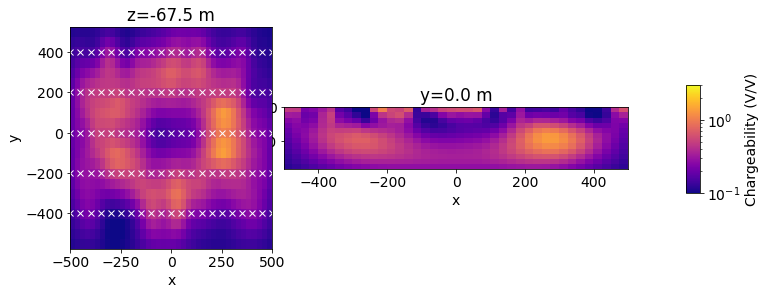

In [12]:
yc = 0
indy = int(np.argmin(abs(mesh_3d_core.vectorCCy-yc)))
zc = -70
indz = int(np.argmin(abs(mesh_3d_core.vectorCCz-zc)))
cmap = 'plasma'
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 8)
ax1 = plt.subplot(gs[0, 3:])
ax2 = plt.subplot(gs[0, :3])
vmin, vmax = 0.1, 3
out = mesh_3d_core.plotSlice(
    tau_est[core_3d_inds], grid=False, normal="Y", clim=(vmin, vmax), pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, ax=ax1, ind=indy
)
ax1.set_aspect("equal")
ax1.set_title(("y=%.1f m")%(mesh_3d_core.vectorCCy[indy]))
out = mesh_3d_core.plotSlice(
    tau_est[core_3d_inds], grid=False, normal="Z", clim=(vmin, vmax), ind=indz, pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, 
    ax=ax2
)
ax2.set_aspect(1)
ax2.set_title(("z=%.1f m")%(mesh_3d_core.vectorCCz[indz]))
ax2.plot(IO_3d.electrode_locations[:,0], IO_3d.electrode_locations[:,1], 'wx', markeredgewidth=1.)
cbaxes = fig.add_axes([0.98, 0.35, 0.02, 0.3]) 
cb=plt.colorbar(
    out[0], cax=cbaxes, orientation="vertical", ax=ax1
)

cb.set_label("Chargeability (V/V)")
for ax in [ax1, ax2]:
    ax.set_xlim(-500, 500)
#     ax.set_ylim(-500, 500)    
plt.tight_layout()


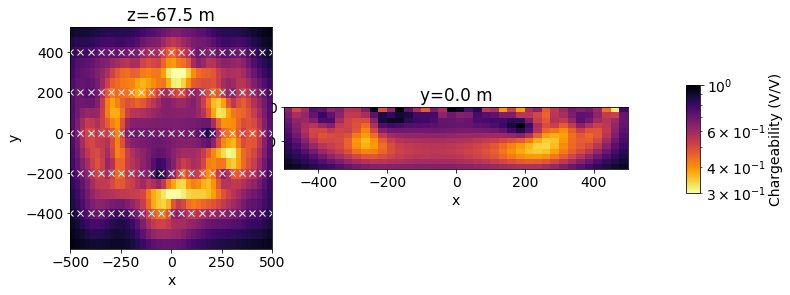

In [13]:
yc = 0
indy = int(np.argmin(abs(mesh_3d_core.vectorCCy-yc)))
zc = -70
indz = int(np.argmin(abs(mesh_3d_core.vectorCCz-zc)))
cmap = 'inferno_r'
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 8)
ax1 = plt.subplot(gs[0, 3:])
ax2 = plt.subplot(gs[0, :3])
vmin, vmax = 0.3, 1.
out = mesh_3d_core.plotSlice(
    c_est[core_3d_inds], grid=False, normal="Y", clim=(vmin, vmax), pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, ax=ax1, ind=indy
)
ax1.set_aspect("equal")
ax1.set_title(("y=%.1f m")%(mesh_3d_core.vectorCCy[indy]))
out = mesh_3d_core.plotSlice(
    c_est[core_3d_inds], grid=False, normal="Z", clim=(vmin, vmax), ind=indz, pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, 
    ax=ax2
)
ax2.set_aspect(1)
ax2.set_title(("z=%.1f m")%(mesh_3d_core.vectorCCz[indz]))
ax2.plot(IO_3d.electrode_locations[:,0], IO_3d.electrode_locations[:,1], 'wx', markeredgewidth=1.)
cbaxes = fig.add_axes([0.98, 0.35, 0.02, 0.3]) 
cb=plt.colorbar(
    out[0], cax=cbaxes, orientation="vertical", ax=ax1
)

cb.set_label("Chargeability (V/V)")
for ax in [ax1, ax2]:
    ax.set_xlim(-500, 500)
#     ax.set_ylim(-500, 500)    
plt.tight_layout()
